In [1]:
from collections import namedtuple
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
print(os.listdir())
import sys
# sys.path.append('..')
sys.path.append('../../../sampler-comparison')
# sys.path.append('../../')
from sampler_comparison.samplers import samplers
# import seaborn as sns

from sampler_evaluation.models import models
from sampler_evaluation.models.standardgaussian import Gaussian


import pymc as pm
import numpy as np

import pymc
from pymc.sampling.jax import get_jaxified_logp

# import numpyro
# import numpyro.distributions as dist
# from numpyro.infer.reparam import TransformReparam





2025-02-18 15:12:06.555209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739920326.577436  388586 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739920326.597770  388586 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 15:12:06.705654: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


['debug.ipynb', 'other_ppls.ipynb', 'debug.py', 'demo.ipynb', 'other_ppls_2.ipynb']


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


['debug.ipynb', 'other_ppls.ipynb', 'debug.py', 'demo.ipynb', 'other_ppls_2.ipynb']


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

In [10]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

basic_model = pm.Model()

with basic_model as model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)


    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

# import numpy as np


J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

import pymc as pm


with basic_model as model:

    mu = pm.Normal("mu", mu=0.0, sigma=10.0)
    # tau = pm.HalfCauchy("tau", 5.0)

    # theta = pm.Normal("theta", mu=0, sigma=1, shape=J)
    # theta_1 = mu + tau * theta
    # obs = pm.Normal("obs", mu=theta_1, sigma=sigma, shape=J, observed=y)

In [5]:
log_density_fn = get_jaxified_logp(model)

In [6]:
Model = namedtuple('Model', ['ndims', 'log_density_fn', 'default_event_space_bijector'])


def from_pymc(model):

    log_density_fn = get_jaxified_logp(model)

    rvs = [rv.name for rv in model.value_vars]

    init_position_dict = model.initial_point()
    init_position = [init_position_dict[rv] for rv in rvs]

    return Model(ndims=len(init_position), log_density_fn=log_density_fn, default_event_space_bijector=lambda x:x), init_position




In [7]:
model, init_position = from_pymc(model)

samples, metadata = samplers['nuts'](return_samples=True)(
        model=model, 
        num_steps=1000,
        initial_position=init_position, 
        key=jax.random.PRNGKey(0))

(1000, 2)

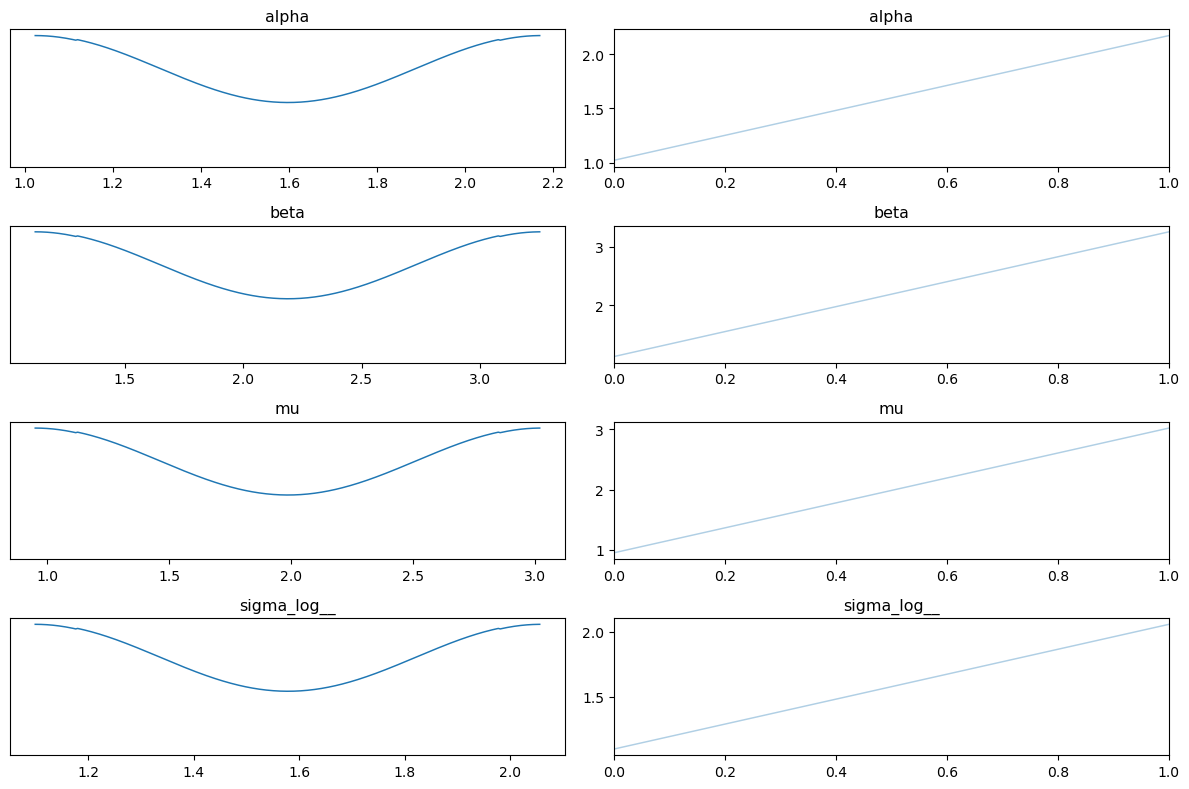

In [16]:
import arviz as az

states = samples[1]

idata = az.from_dict(
    posterior={k: v[None, ...]
               for k, v in zip(model.initial_point().keys(), states)})
az.plot_trace(idata)
plt.tight_layout()

In [ ]:
rng_key, init_key = jax.random.split(jax.random.key(0))
init_params, potential_fn_gen, *_ = initialize_model(
    init_key,
    eight_schools_noncentered,
    model_args=(J, sigma, y),
    dynamic_args=True,
)

logdensity_fn = lambda position: -potential_fn_gen(J, sigma, y)(position)
init_position = init_params.z